In [1]:
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.utils.tensorboard import SummaryWriter
import torch.utils.checkpoint as checkpoint
import torch.utils.data

import matplotlib.pyplot as plt

from torchvision.io import read_image

import os
import nibabel as nib
import numpy as np
from torch.utils.data import Dataset

import torchvision.transforms.functional

from PIL import Image

from sklearn import preprocessing
import SimpleITK as sitk

from sklearn.metrics import jaccard_score

In [2]:
# MedNeXt single block (upsampling/downsampling also included)

class MedNeXt_block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, expansion_ratio, output_padding = 1):
        super(MedNeXt_block, self).__init__()
        # Depthwise convolution layer
        stride = 1
        if in_channels != out_channels: stride = 2
        self.depthwise_conv = nn.Conv3d(in_channels, out_channels = in_channels, stride = stride,
                                        kernel_size=kernel_size, padding = (kernel_size - 1) // 2)
        
        self.depthwise_transpose = nn.ConvTranspose3d(in_channels, out_channels = in_channels,
                                                      stride = stride, kernel_size=kernel_size,
                                                      padding = 2, output_padding = output_padding)

        self.group_norm = nn.GroupNorm(num_groups=in_channels, num_channels=in_channels)

        # Expansion layer
        self.expansion_conv = nn.Conv3d(in_channels, in_channels * expansion_ratio, 
                              kernel_size = 1)
        self.activation = nn.GELU()

        # Compression layer
        self.compression_conv = nn.Conv3d(in_channels * expansion_ratio, out_channels,
                              kernel_size = 1)
        
        # Residuals
        self.conv = nn.Conv3d(in_channels, out_channels, stride = 2, kernel_size = 1)
        self.conv_transpose = nn.ConvTranspose3d (in_channels, out_channels, stride = 2,
                                                  kernel_size = 1, output_padding = output_padding)
        
        self.ratio = out_channels/in_channels

    def forward(self, x):
        if self.ratio == 0.5: out = self.depthwise_transpose(x)
        else: out = self.depthwise_conv(x)
        
        #print ("dw", out.shape)
        out = self.group_norm(out)
        #print ("grp norm", out.shape)
        out = self.expansion_conv(out)
        #print ("exp", out.shape)
        out = self.activation(out)
        out = self.compression_conv(out)
        #print ("comp", out.shape)
        
        residual = x
        #print(residual.shape)
        #print("final", out.shape)
        if self.ratio == 2: 
            residual = self.conv(x)
        elif self.ratio == 0.5:
            residual = self.conv_transpose(x)
        #print("resid", residual.shape)
        return out + residual

In [3]:
# encoder 1: ([1, 8, 120, 120, 78])
# encoder 2: ([1, 16, 60, 60, 39])
# decoder 1: ([1, 8, 120, 120, 78])
# decoder 2: ([1, 4, 240, 240, 155])

sample_input = torch.randn([1, 8, 120, 120, 78])
block = MedNeXt_block(8, 4, 5, 2, output_padding = (1,1,0))
block(sample_input).shape

torch.Size([1, 4, 240, 240, 155])

In [4]:
class MedNeXt_s(nn.Module):
    def __init__(self, in_channels):
        super(MedNeXt_s, self).__init__()
        R = 2 # the expansion ratio
        self.block1 = MedNeXt_block(in_channels, in_channels, 5, R)
        self.encoder1 = MedNeXt_block(in_channels, in_channels*2, 5, R)
        self.block2 = MedNeXt_block(in_channels*2, in_channels*2, 5, R)
        self.encoder2 = MedNeXt_block(in_channels*2, in_channels*4, 5, R)

        self.bottleneck = MedNeXt_block(in_channels*4, in_channels*4, 5, R)

        self.decoder1 = MedNeXt_block(in_channels*4, in_channels*2, 5, R)
        self.block3 = MedNeXt_block(in_channels*2, in_channels*2, 5, R)
        self.decoder2 = MedNeXt_block(in_channels*2, in_channels, 5, R, output_padding = (1,1,0))
        self.block4 = MedNeXt_block(in_channels, in_channels, 5, R)

    def forward (self, x):
        out1 = self.block1(x)
        #print (out1.shape)
        out2 = self.encoder1(out1)
        out2 = self.block2(out2)
        #print (out2.shape)
        out3 = self.encoder2(out2)
        #print (out3.shape)
        out3 = self.bottleneck(out3)
        out3 = self.decoder1(out3)
        #print (out3.shape, out2.shape)
        out = self.block3(out3 + out2)
        out = self.decoder2(out)
        #print (out.shape, out1.shape)
        out = self.block4 (out + out1)
        return nn.Softmax(dim=1)(out)

In [5]:
class MedNeXt_b(nn.Module):
    def __init__(self, in_channels):
        super(MedNeXt_b, self).__init__()
        R = 2 # the expansion ratio
        self.block1 = nn.Sequential (
            MedNeXt_block(in_channels, in_channels, 5, R),
            MedNeXt_block(in_channels, in_channels, 5, R)
        )
        self.encoder1 = MedNeXt_block(in_channels, in_channels*2, 5, R)
        self.block2 = nn.Sequential (
            MedNeXt_block(in_channels*2, in_channels*2, 5, R),
            MedNeXt_block(in_channels*2, in_channels*2, 5, R)
        )
        self.encoder2 = MedNeXt_block(in_channels*2, in_channels*4, 5, R)
        self.block3 = nn.Sequential (
            MedNeXt_block(in_channels*4, in_channels*4, 5, R),
            MedNeXt_block(in_channels*4, in_channels*4, 5, R)
        )
        self.encoder3 = MedNeXt_block(in_channels*4, in_channels*8, 5, R)
        self.block4 = nn.Sequential (
            MedNeXt_block(in_channels*8, in_channels*8, 5, R),
            MedNeXt_block(in_channels*8, in_channels*8, 5, R)
        )
        self.encoder4 = MedNeXt_block(in_channels*8, in_channels*16, 5, R)

        self.bottleneck= nn.Sequential (
            MedNeXt_block(in_channels*16, in_channels*16, 5, R),
            MedNeXt_block(in_channels*16, in_channels*16, 5, R)
        )

        self.decoder1 = MedNeXt_block(in_channels*16, in_channels*8, 5, R, output_padding = (0, 0, 1))
        self.block5 = nn.Sequential (
            MedNeXt_block(in_channels*8, in_channels*8, 5, R),
            MedNeXt_block(in_channels*8, in_channels*8, 5, R)
        )
        self.decoder2 = MedNeXt_block(in_channels*8, in_channels*4, 5, R, output_padding = (1,1,0))
        self.block6 = nn.Sequential (
            MedNeXt_block(in_channels*4, in_channels*4, 5, R),
            MedNeXt_block(in_channels*4, in_channels*4, 5, R)
        )
        self.decoder3 = MedNeXt_block(in_channels*4, in_channels*2, 5, R)
        self.block7 = nn.Sequential (
            MedNeXt_block(in_channels*2, in_channels*2, 5, R),
            MedNeXt_block(in_channels*2, in_channels*2, 5, R)
        )
        self.decoder4 = MedNeXt_block(in_channels*2, in_channels, 5, R, output_padding = (1,1,0))
        self.block8 = nn.Sequential (
            MedNeXt_block(in_channels, in_channels, 5, R),
            MedNeXt_block(in_channels, in_channels, 5, R)
        )

    def forward (self, x):
        out1 = self.block1(x)
        #print (out1.shape)
        out2 = self.encoder1(out1)
        out2 = self.block2(out2)
        #print (out2.shape)
        out3 = self.encoder2(out2)
        out3 = self.block3(out3)
        #print (out3.shape)
        out4 = self.encoder3(out3)
        out4 = self.block4(out4)
        #print (out4.shape)
        out = self.encoder4(out4)

        out = self.bottleneck (out)

        out = self.decoder1(out)
        #print (out.shape)
        out += out4
        out = self.block5(out)
        out = self.decoder2(out)
        #print (out.shape)
        out += out3
        out = self.block6(out)
        out = self.decoder3(out)
        #print (out.shape)
        out += out2 
        out = self.block7(out)
        out = self.decoder4(out)
        #print (out.shape)
        out += out1 
        out = self.block8(out)

        return nn.Softmax(dim=1)(out)

In [6]:
sample_input = torch.randn([5, 120, 120, 155]).unsqueeze(dim = 0)
test_model = MedNeXt_b(5)
print(test_model(sample_input).shape, "shape of resized sample")

torch.Size([1, 5, 120, 120, 155]) shape of resized sample


In [7]:
sample_input = torch.randn([5, 240, 240, 155]).unsqueeze(dim = 0)
block = MedNeXt_s(5)
print(block(sample_input).shape, "shape of big sample")

torch.Size([1, 5, 240, 240, 155]) shape of big sample


In [8]:
def plot_image (np_arr, sizex = 6, sizey = 6):
    fig, ax = plt.subplots(figsize=(sizex, sizey))
    ax.imshow(np_arr, cmap='gray')
    plt.show()

In [9]:
"""
0: Background - This class represents the healthy brain tissue and is the majority class in the dataset.
1: Necrosis and Non-Enhancing Tumor - This class represents the non-enhancing tumor and the necrotic core of the enhancing tumor.
2: Edema - This class represents the edema surrounding the tumor.
3: Enhancing Tumor - This class represents the enhancing tumor."""

class BraTS2021Dataset(Dataset):
    def __init__(self, data_dir, isResized = False):
        self.data_dir = data_dir
        self.patient_ids = os.listdir(data_dir)

        self.isResized = isResized

    def __len__(self):
        return len(self.patient_ids)

    def __getitem__(self, idx):
        patient_id = self.patient_ids[idx]
        scan_files = [os.path.join(self.data_dir, patient_id, f'{patient_id}_{modality}.nii.gz')
                      for modality in ['t1', 't2', 't1ce', 'flair']]
        mask_file = os.path.join(self.data_dir, patient_id, f'{patient_id}_seg.nii.gz')

        # Load scan files and concatenate into a 4-channel tensor
        # In the BraTS dataset specifically, each patient has four MRI scans available: 
        # T1-weighted, T1-weighted with contrast enhancement (T1ce), T2-weighted, and FLAIR. 
        # By concatenating these four scans into a single 4-channel tensor, we can provide 
        # the model with more information about the anatomy being imaged.
        
        scans = []
        for scan_file in scan_files:
            scan_data = nib.load(scan_file).get_fdata()
            scans.append(scan_data)
        scans_tensor = np.stack(scans, axis=0)
        
        # Load mask file and convert to integer labels
        mask_data = nib.load(mask_file).get_fdata()
        mask_tensor = (mask_data > 0).astype(np.int64) + (mask_data == 4).astype(np.int64) * 2
        
        one_hot = (scans_tensor[0]!= 0).astype(np.int64)
        one_hot = torch.from_numpy(one_hot).unsqueeze(dim = 0) # Add channel dimensions
        #print (one_hot.shape, one_hot)

        # Normalize scans and convert to PyTorch tensor
        for channel_num in range(scans_tensor.shape[0]):
            channel_data = scans_tensor[channel_num]
            channel_data = scans_tensor[channel_num]
            non_zero_indices = np.nonzero(channel_data)

            mean = np.mean(channel_data[non_zero_indices])
            std = np.std(channel_data[non_zero_indices])

            channel_data[non_zero_indices] -= mean
            channel_data[non_zero_indices] /= std
            
            scans_tensor[channel_num] = channel_data
        
        #print(scans_tensor.shape, type(scans_tensor))
        #print(mask_tensor.shape, type(mask_tensor))

        scans_tensor = torch.from_numpy(scans_tensor)
        mask_tensor = torch.from_numpy(mask_tensor)

        scans_tensor = torch.cat([scans_tensor, one_hot], dim=0)

        if self.isResized == True:
            # Resize everything
            scan = scans_tensor.unsqueeze(0)
            mask = mask_tensor.unsqueeze(0).unsqueeze(0).float()

            # Resize the tensors
            new_size = (120, 120, 155)
            scan_resized = F.interpolate(scan, size=new_size, mode='trilinear', align_corners=False)
            mask_resized = F.interpolate(mask, size=new_size, mode='nearest')

            # Remove the batch dimension
            scans_tensor = scan_resized.squeeze(0)
            mask_tensor = mask_resized.squeeze(0).squeeze(0)

        return scans_tensor.float(), mask_tensor.long()

Scan tensor shape: torch.Size([5, 120, 120, 155])
Mask tensor shape: torch.Size([120, 120, 155])
Dataset length 1251


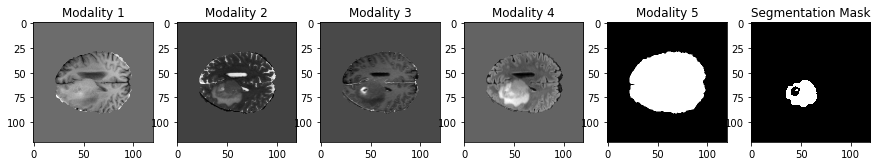

In [10]:
# Test the main dataset

data_dir = 'C:/Users/alist/WorkCodes/Datasets/BRATS2021TRAINDATASET'
dataset = BraTS2021Dataset(data_dir, isResized = True)

# Load a single patient's MRI scan and segmentation mask
patient_idx = 1
scan, mask = dataset[patient_idx]

new_tensor = torch.zeros_like(mask) # Initialize new tensor with all zeros
new_tensor[mask == 1] = 1 
mask = new_tensor

# Print shape of scan and mask tensors
print('Scan tensor shape:', scan.shape)
print('Mask tensor shape:', mask.shape)
print('Dataset length', len(dataset))

slice_idx = 100
# Visualize the scan and mask using matplotlib
fig, axs = plt.subplots(1, 6, figsize=(15, 5))
for i in range(5):
    axs[i].imshow(scan[i][:, :, slice_idx], cmap='gray')
    axs[i].set_title(f'Modality {i+1}')
axs[5].imshow(mask[:, :, slice_idx], cmap='gray')
axs[5].set_title('Segmentation Mask')
plt.show()

In [11]:
import torch.utils.data

class AugmentedDataset(Dataset):
    """
    Custom dataset for augmentation for the BRATS dataset
    """
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
        
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        scan, mask = self.dataset[idx]
        if self.transform:
            transformed_tensor = self.transform(
                torch.cat([mask.unsqueeze(0), scan], dim=0).permute(3, 0, 1, 2)
            )
            #print(transformed_tensor.shape)
            transformed_tensor = transformed_tensor.permute(1, 2, 3, 0)
            #print(transformed_tensor.shape)
            mask = transformed_tensor[0, :, :, :]
            scan = transformed_tensor[1:, :, :, :]

        return scan, mask
        
# Augmentations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=1, sigma=(0.5, 1.5))], p=0.15),
    transforms.RandomApply([transforms.RandomCrop((120, 120), padding=None, pad_if_needed=False, fill=0, padding_mode='constant')], p=0.4),
])

torch.manual_seed(21)

# Define split sizes
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Split the whole dataset into train and test dataset. Is validation needed?
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_dataset = AugmentedDataset(train_dataset, transform)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
model = MedNeXt_b(5).to(device)

In [13]:
def Dice(output, target, eps=1e-5):
        target = target.float()
        num = 2 * (output * target).sum()
        den = output.sum() + target.sum() + eps
        return 1.0 - num/den

class softmax_dice(nn.Module):
    '''
    The dice loss for using softmax activation function
    :param output: (b, num_class, d, h, w)
    :param target: (b, d, h, w)
    :return: softmax dice loss
    '''
    def __init__(self):
        super(softmax_dice, self).__init__()
        
    def forward(self, output, target):
        target[target == 4] = 3 
        output = output.cuda()
        target = target.cuda()
        loss0 = Dice(output[:, 0, ...], (target == 0).float())
        loss1 = Dice(output[:, 1, ...], (target == 1).float())
        loss2 = Dice(output[:, 2, ...], (target == 2).float())
        loss3 = Dice(output[:, 3, ...], (target == 3).float())

        return loss1 + loss2 + loss3 + loss0 #, 1-loss1.data, 1-loss2.data, 1-loss3.data

In [14]:
# Define hyperparameters
learning_rate = 0.001
num_epochs = range(5, 10)

# Define dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=False)

# Define loss function and optimizer
#criterion = nn.CrossEntropyLoss()
criterion = softmax_dice()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001)

# Load checkpoint ==============================
checkpoint = torch.load('checkpoint-4.pth')

# Extract relevant data from checkpoint
#epoch = checkpoint['epoch']
model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#loss = checkpoint['loss']
# ==============================================

softmax = nn.Softmax(dim = 1)

model.train()

running_loss = 0

for epoch in num_epochs:
    
    running_loss = 0.0
    totalTestLoss = 0

    model.train()

    for counter, (images, labels) in enumerate(train_loader):
        outputs = model(images.cuda())
        loss = criterion(outputs, labels.long())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        # print("running_loss", loss.item())
        
        if counter % 20 == 19:
            torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss.item(),
            },  'checkpoint-'+ str(epoch) +'.pth')
            print( "epoch:", epoch, "iteration:", counter, "Average cost function", running_loss/20)
            running_loss = 0
    
    model.eval()
    total_iou = 0
    print ("=======================================\nValidation started...")
    for i in test_dataset:
        scan = i[0].unsqueeze(dim = 0) 
        out = model(scan.to(device)).cpu()
        mask = i[1].cpu()  
        class_index = torch.argmax(out, dim=1).cpu()
        iou = jaccard_score(mask.flatten(), class_index.flatten(), average='macro')
        total_iou += iou
    print ("Validation is over. Total IOU score is", total_iou/250,"\n=======================================")
    

KeyboardInterrupt: 

IoU: 0.8257686517520479


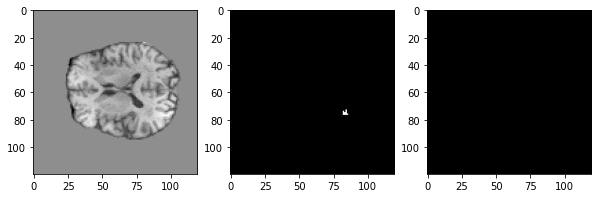

IoU: 0.9148821149952543


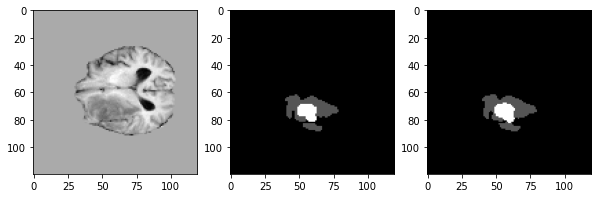

IoU: 0.626463189238867


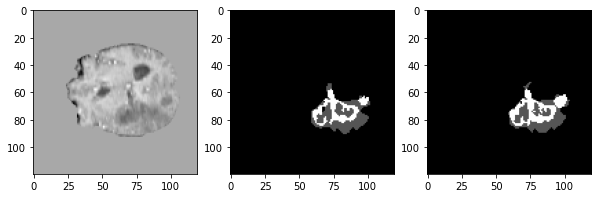

IoU: 0.7840462213579434


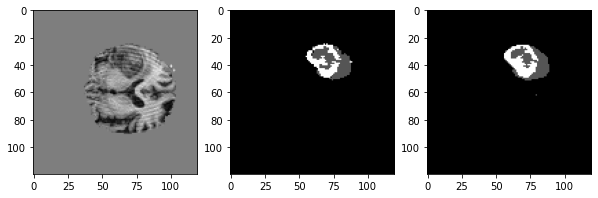

IoU: 0.6219318306294637


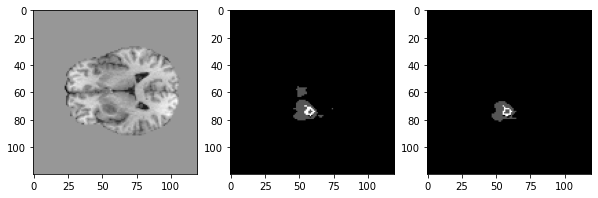

IoU: 0.6663523794508662


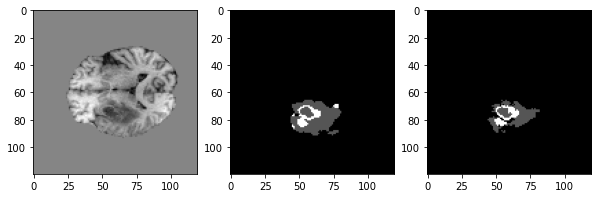

IoU: 0.7752384604419023


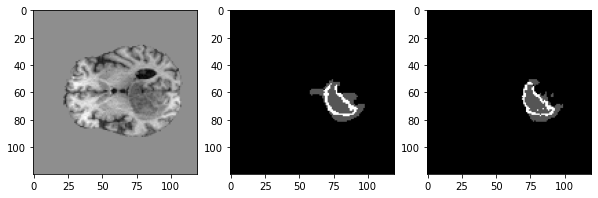

IoU: 0.9120373528704396


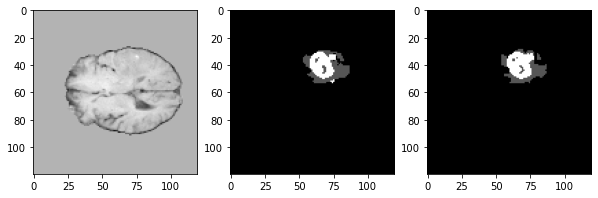

IoU: 0.7572793149109427


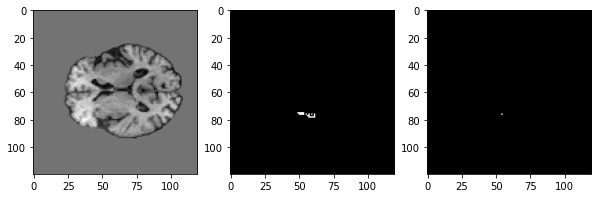

IoU: 0.6058086656321373


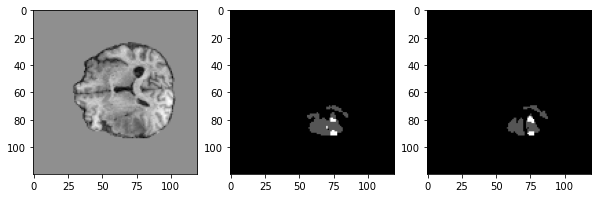

IoU: 0.8586075091554376


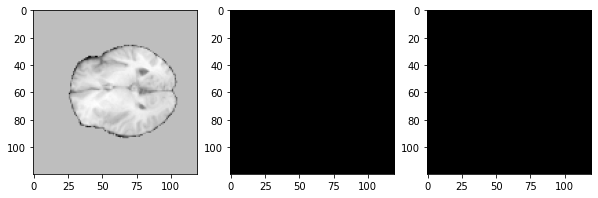

IoU: 0.6603658982504023


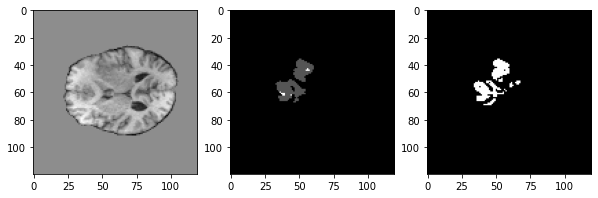

IoU: 0.5986566129577043


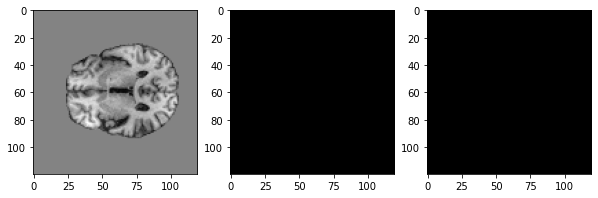

IoU: 0.788634366273918


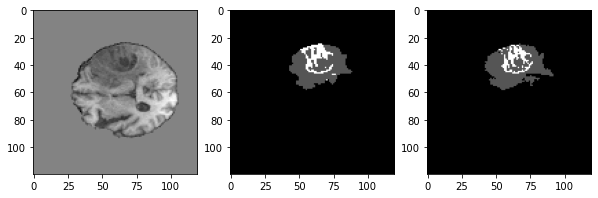

IoU: 0.8654587634377465


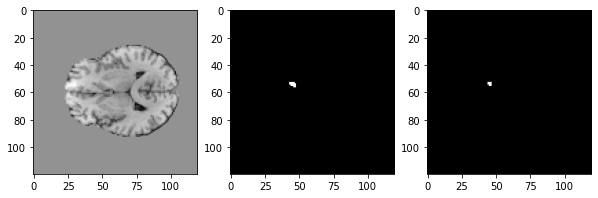

IoU: 0.9171465248681357


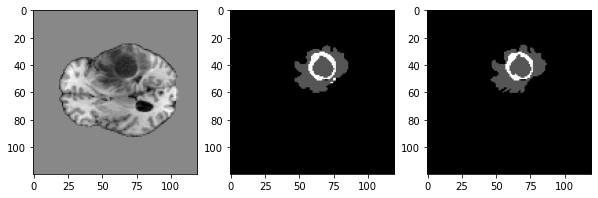

IoU: 0.8314309710085541


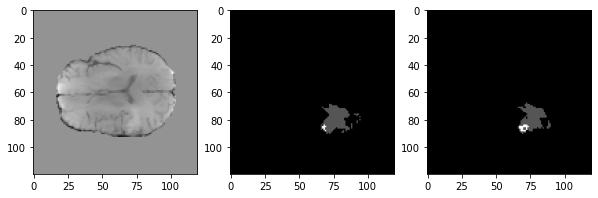

IoU: 0.9197489523172896


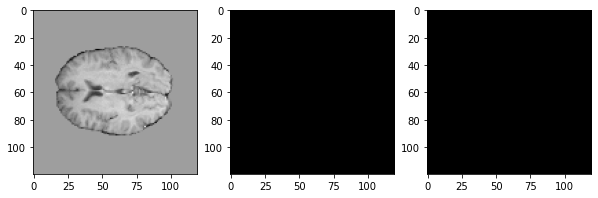

IoU: 0.8934987757865375


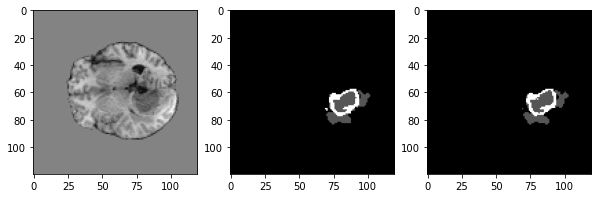

IoU: 0.4959579351480598


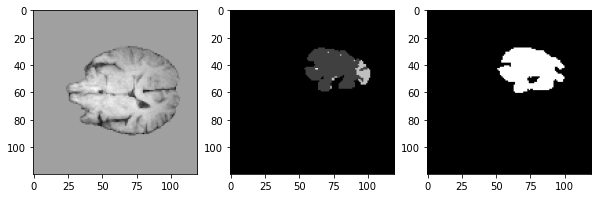

IoU: 0.6888498159006181


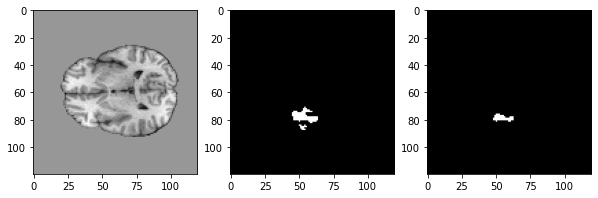

IoU: 0.6996455694335206


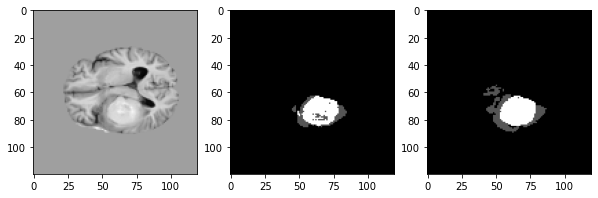

IoU: 0.6767118452262223


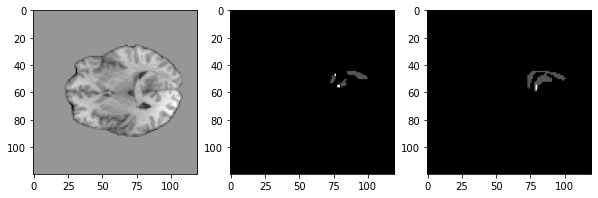

IoU: 0.8023328276761994


KeyboardInterrupt: 

In [36]:
"""
A few examples
"""
for i in test_dataset:
    scan = i[0].unsqueeze(dim = 0) # => [1, 4, 240, 240, 155]
    mask = i[1]

    model.eval()
    layer = 70

    out = model(scan.to(device))

    class_index = torch.argmax(out, dim=1).cpu()
    iou = jaccard_score(mask.flatten(), class_index.flatten(), average='macro')
    print(f"IoU: {iou}")
    
    fig, axs = plt.subplots(1, 3, figsize=(10, 5))    
    axs[0].imshow(scan[0][0][:, :,layer].cpu().detach().numpy(), cmap='gray')
    axs[1].imshow(class_index[0][:, :, layer].cpu().detach().numpy(), cmap='gray')
    axs[2].imshow(mask[:, :, layer].cpu().detach().numpy(), cmap='gray')
    plt.show()

In [15]:
from sklearn.metrics import jaccard_score
import torch

model.eval()


total_iou = 0

for i in test_dataset:
    scan = i[0].unsqueeze(dim = 0) 
    out = model(scan.to(device)).cpu()
    #print(out.shape)

    mask = i[1].cpu()  
    #print(mask.shape)
    class_index = torch.argmax(out, dim=1).cpu()
    # Compute the intersection over union (IoU) metric
    iou = jaccard_score(mask.flatten(), class_index.flatten(), average='macro')

    """fig, axs = plt.subplots(1, 2, figsize=(3, 1))    
    axs[0].imshow(class_index[0][:, :].cpu().detach().numpy(), cmap='gray')
    axs[1].imshow(mask[0][:, :].cpu().detach().numpy(), cmap='gray')
    plt.show()"""

    # Print the IoU metric
    print(f"IoU: {iou}")

    total_iou += iou
print ("total IOU score is", total_iou/250)

IoU: 0.8699966104604169
IoU: 0.8853449669888175
IoU: 0.8172585573950589
IoU: 0.32967010155316606
IoU: 0.43573611659055966
IoU: 0.46586419118852007
IoU: 0.5716484446041793
IoU: 0.9056787804407435
IoU: 0.5248730747080339
IoU: 0.7946936326081838
IoU: 0.8468983622236745
IoU: 0.47941886743100953
IoU: 0.608570698023687
IoU: 0.5872193106620924
IoU: 0.6702897223922162
IoU: 0.5289709957860521
IoU: 0.5713392873580275
IoU: 0.9085572830590697
IoU: 0.6856328515472045
IoU: 0.4349611664919282
IoU: 0.5402486660070446
IoU: 0.5091982579189762
IoU: 0.5251638899240363
IoU: 0.476211997450746
IoU: 0.6990040009299235
IoU: 0.8161971072384073
IoU: 0.7726592029587779
IoU: 0.4502585596848762
IoU: 0.7652519900207907
IoU: 0.8515575855531973
IoU: 0.8841198159091457
IoU: 0.837054007042109
IoU: 0.6788782570792211
IoU: 0.6910375628874886
IoU: 0.5970840820656452
IoU: 0.7550246379103353
IoU: 0.679098716207039
IoU: 0.4059249346684294
IoU: 0.5797003269170746
IoU: 0.8678891248187174
IoU: 0.4329941843291283
IoU: 0.607102001

In [21]:
import glob
import os
from argparse import ArgumentDefaultsHelpFormatter, ArgumentParser

import nibabel
import numpy as np
from tqdm import tqdm

parser = ArgumentParser(formatter_class=ArgumentDefaultsHelpFormatter)
parser.add_argument("--preds", type=str, required=True, help="Path to predictions")
parser.add_argument("--lbls", type=str, required=True, help="Path to labels")


def get_stats(pred, targ, class_idx):
    tp = np.logical_and(pred == class_idx, targ == class_idx).sum()
    fn = np.logical_and(pred != class_idx, targ == class_idx).sum()
    fp = np.logical_and(pred == class_idx, targ != class_idx).sum()
    return tp, fn, fp


In [23]:
from sklearn.metrics import jaccard_score
import torch

model.eval()


total_volumetric = 0

for i in test_dataset:
    scan = i[0].unsqueeze(dim = 0) 
    out = model(scan.to(device)).cpu()
    #print(out.shape)

    mask = i[1].cpu()  
    #print(mask.shape)
    class_index = torch.argmax(out, dim=1)[0].cpu()
    dice = []
    for i in [1, 2, 3]:
        counts = np.count_nonzero(mask == i) + np.count_nonzero(class_index == i)
        if counts == 0:  # no foreground class
            dice[i - 1].append(1)
        else:
            tp, fn, fp = get_stats(class_index, mask, i)
            denum = 2 * tp + fp + fn
            dice[i - 1].append(2 * tp / denum if denum != 0 else 0)
    print (dice)

# Compute the average DSC and NSD scores across all labels
#avg_dsc = np.mean(dsc_scores)
#avg_nsd = np.mean(nsd_scores)
#print ("total IOU score is", total_volumetric/250)

IndexError: list index out of range

In [ ]:
# 0.91